[0.08012, 0.0786, 0.07527, 0.06985, 0.06212, 0.05424, 0.0472, 0.0414, 0.0367, 0.03323, 0.03057, 0.02865, 0.0272, 0.02603, 0.02508, 0.02428, 0.02361, 0.02304, 0.02253, 0.02206, 0.0217, 0.02136, 0.02109, 0.02084, 0.02066, 0.02048, 0.02035, 0.02018, 0.02002, 0.01988, 0.0198, 0.01971, 0.01954, 0.01947, 0.01941, 0.01936, 0.01927, 0.0192, 0.01917, 0.01911, 0.01907, 0.01902, 0.01901, 0.01893, 0.01888, 0.01885, 0.01884, 0.01881, 0.01881, 0.01875, 0.01871, 0.01873, 0.01873, 0.01869, 0.01867, 0.01862, 0.0186, 0.01861, 0.0186, 0.01861, 0.0186, 0.01856, 0.01855, 0.0185, 0.01851, 0.01846, 0.01846, 0.01845, 0.01843, 0.0184, 0.0184, 0.01839, 0.01837, 0.01834, 0.01833, 0.01828, 0.01827, 0.0183, 0.01832, 0.01826, 0.01826, 0.01828, 0.01827, 0.01824, 0.0182, 0.01818, 0.01818, 0.01819, 0.01816, 0.01816, 0.01814, 0.01814, 0.01813, 0.01812, 0.01814, 0.01811, 0.01809, 0.01809, 0.01808, 0.0181]
[0.093, 0.08236, 0.10745, 0.11134, 0.11092, 0.11338, 0.10742, 0.1125, 0.10857, 0.11091, 0.10588, 0.11072, 0.10627, 0

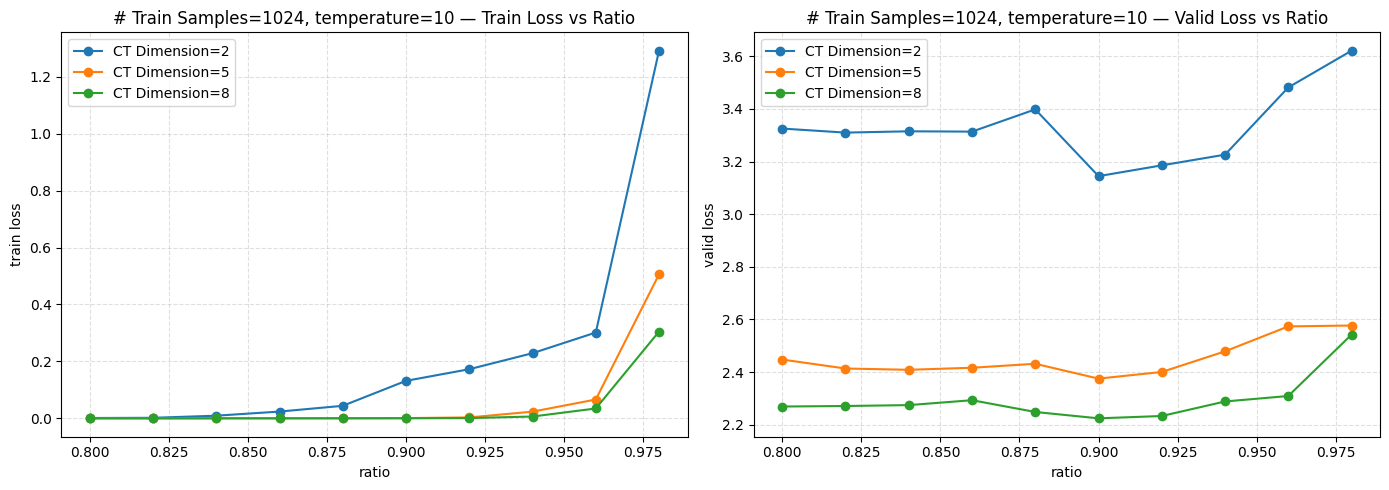

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ===========================================================
# 1. 解析单个日志文件（只取最后一个值）
# ===========================================================

re_train = re.compile(r"train loss:\s*([\d\.Ee+\-]+)")
re_valid = re.compile(r"valid loss:\s*([\d\.Ee+\-]+)")
re_dyn = re.compile(r"dyn_dyn_loss\s*:\s*([\d\.Ee+\-]+)")


def parse_log_last(path):
    train_vals, valid_vals, dyn_vals = [], [], []

    with open(path, "r") as f:
        for line in f:
            m = re_train.search(line)
            if m:
                train_vals.append(float(m.group(1)))

            m = re_valid.search(line)
            if m:
                valid_vals.append(float(m.group(1)))

            m = re_dyn.search(line)
            if m:
                dyn_vals.append(float(m.group(1)))
    print(dyn_vals)
    return {
        "train_loss": train_vals[-1] if train_vals else None,
        "valid_loss": valid_vals[-1] if valid_vals else None,
        "dyn_loss":   dyn_vals[-1] if dyn_vals else None,
    }



# ===========================================================
# 2. 从文件名解析参数
# ===========================================================

def parse_filename(fname):
    m = re.search(r"N(\d+)_tp(\d+)_temp(\d+)_ratio([0-9.]+).log", fname)
    if not m:
        return None
    return {
        "N": int(m.group(1)),
        "tp": int(m.group(2)),
        "t": int(m.group(3)),
        "ratio": float(m.group(4)),
    }


# ===========================================================
# 3. 读取全部日志
# ===========================================================

def load_all_logs(log_dir):
    results = {}  # results[N][tp][t][ratio]

    for fname in os.listdir(log_dir):
        if not fname.endswith(".log"):
            continue

        params = parse_filename(fname)
        if params is None:
            continue

        path = os.path.join(log_dir, fname)
        stat = parse_log_last(path)

        N = params["N"]
        tp = params["tp"]
        t = params["t"]
        ratio = params["ratio"]

        results.setdefault(N, {})
        results[N].setdefault(tp, {})
        results[N][tp].setdefault(t, {})
        results[N][tp][t][ratio] = stat

    return results


# ===========================================================
# 4. 绘图（matplotlib）
# ===========================================================

def plot_loss_vs_ratio(results, N, t_filter):
    """
    results[N][tp][t][ratio] -> {train_loss, valid_loss}
    仅绘制指定 temperature (t_filter)
    不同曲线代表不同 tp
    """

    if N not in results:
        raise ValueError(f"No data for N={N}")

    # 所有 tp
    tp_list = sorted(results[N].keys())

    # 准备 figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax_train, ax_valid = ax

    cmap = plt.get_cmap("tab10")

    for i, tp in enumerate(tp_list):
        if t_filter not in results[N][tp]:
            continue

        # ratio -> 数据
        items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])
        ratios = [r for r, _ in items]
        train_vals = [d["train_loss"] for _, d in items]
        valid_vals = [d["valid_loss"] for _, d in items]

        color = cmap(i % 10)

        ax_train.plot(ratios, train_vals, marker="o", color=color, label=f"CT Dimension={tp}")
        ax_valid.plot(ratios, valid_vals, marker="o", color=color, label=f"CT Dimension={tp}")

    ax_train.set_title(f"# Train Samples={N}, temperature={t_filter} — Train Loss vs Ratio")
    ax_valid.set_title(f"# Train Samples={N}, temperature={t_filter} — Valid Loss vs Ratio")

    ax_train.set_xlabel("ratio")
    ax_valid.set_xlabel("ratio")
    ax_train.set_ylabel("train loss")
    ax_valid.set_ylabel("valid loss")

    ax_train.grid(True, linestyle="--", alpha=0.4)
    ax_valid.grid(True, linestyle="--", alpha=0.4)

    ax_train.legend()
    ax_valid.legend()

    plt.tight_layout()
    plt.show()


# ===========================================================
# 5. 使用示例
# ===========================================================

if __name__ == "__main__":
    log_dir = "."
    results = load_all_logs(log_dir)

    # 选择 N = 1024, t = 6 (示例)
    plot_loss_vs_ratio(results, N=1024, t_filter=10)


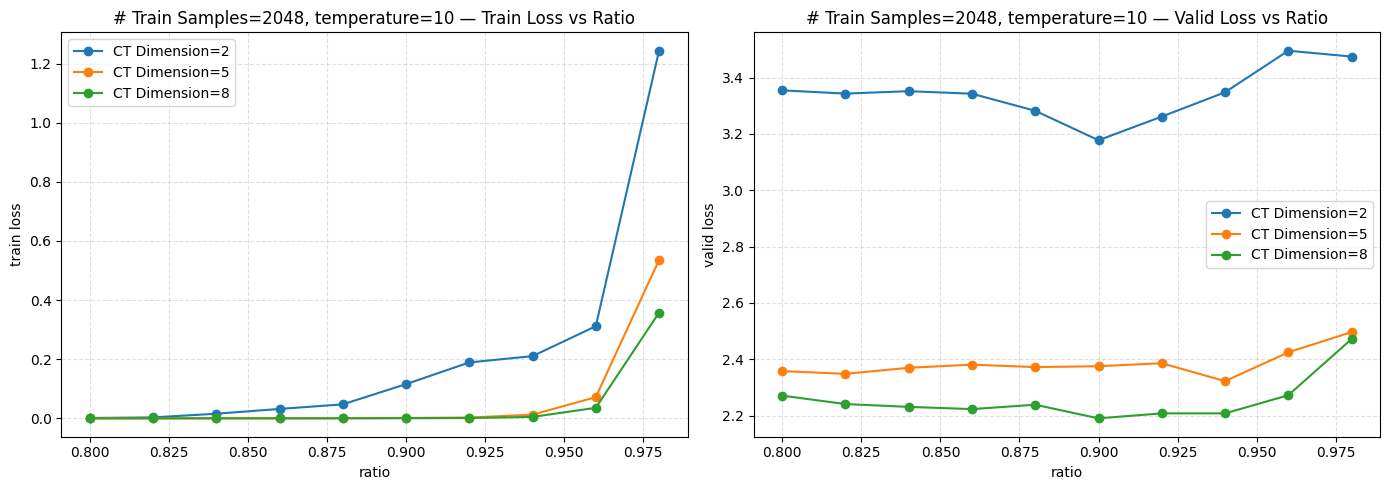

In [2]:
plot_loss_vs_ratio(results, N=2048, t_filter=10)


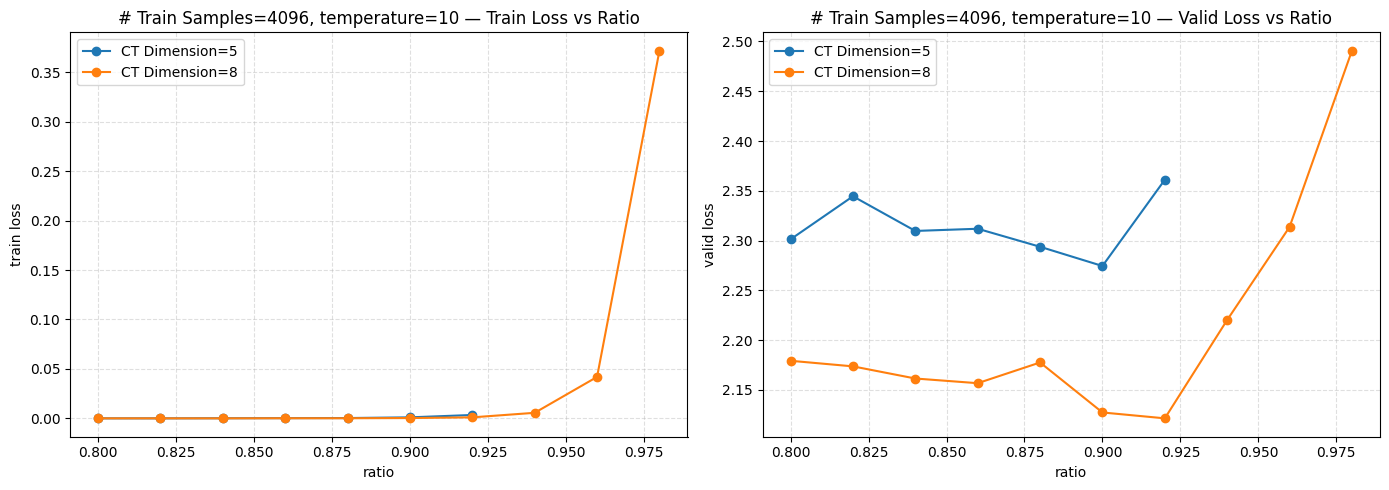

In [3]:
plot_loss_vs_ratio(results, N=4096, t_filter=10)

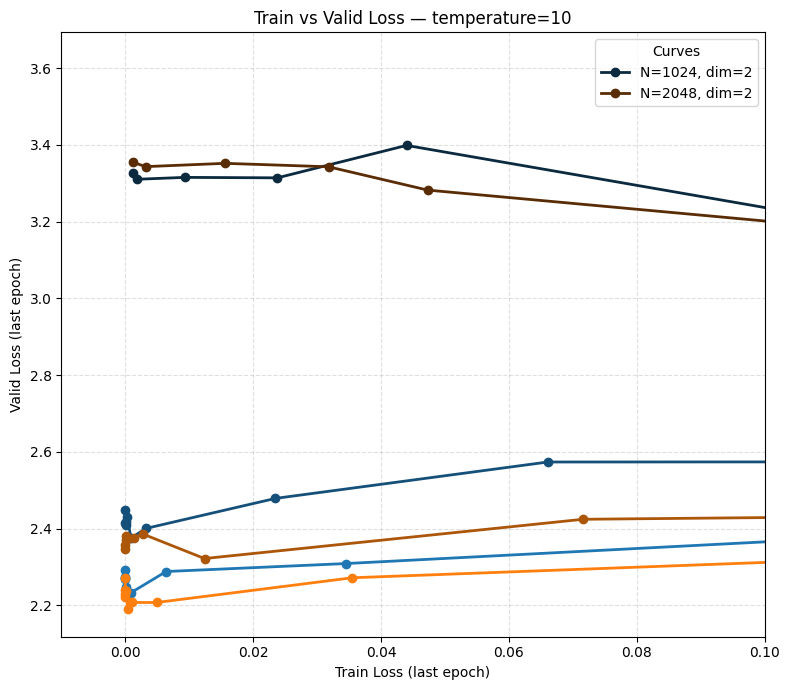

In [4]:
def plot_train_valid_scatter(results, Ns, t_filter):
    """
    绘制 Train Loss vs Valid Loss 曲线图：
    - 横轴：train_loss
    - 纵轴：valid_loss
    - 不同颜色代表不同 N
    - 同一 N 内：不同 tp 通过颜色深浅区分，并绘制为曲线
    """

    fig, ax = plt.subplots(figsize=(8, 7))
    base_cmap = plt.get_cmap("tab10")

    for idx_N, N in enumerate(Ns):
        if N not in results:
            print(f"[Warning] N={N} not found; skip.")
            continue

        # 基础颜色：不同 N → 不同颜色
        base_color = np.array(base_cmap(idx_N % 10))

        tp_list = sorted(results[N].keys())
        num_tp = len(tp_list)

        for i, tp in enumerate(tp_list):

            # 亮度深浅：0.35 → 1.0
            depth = 0.35 + 0.65 * (i / max(1, num_tp - 1))

            color = base_color.copy()
            color[:3] *= depth
            color = np.clip(color, 0, 1)

            if t_filter not in results[N][tp]:
                continue

            # 取出该 N、tp、t 下所有 ratio 的 (train_loss, valid_loss)
            items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])

            ratios = [r for r, _ in items]
            train_vals = [d["train_loss"] for _, d in items]
            valid_vals = [d["valid_loss"] for _, d in items]

            # 画曲线
            ax.plot(train_vals, valid_vals,
                    marker="o",
                    color=color,
                    linewidth=2,
                    label=f"N={N}, dim={tp}" if i == 0 else None)

    ax.set_xlabel("Train Loss (last epoch)")
    ax.set_ylabel("Valid Loss (last epoch)")
    ax.set_title(f"Train vs Valid Loss — temperature={t_filter}")
    # ax.set_xscale("symlog")
    ax.set_xlim([-0.01, 0.1])
    
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(title="Curves")

    plt.tight_layout()
    plt.show()
    
plot_train_valid_scatter(results, Ns=[1024, 2048], t_filter=10)

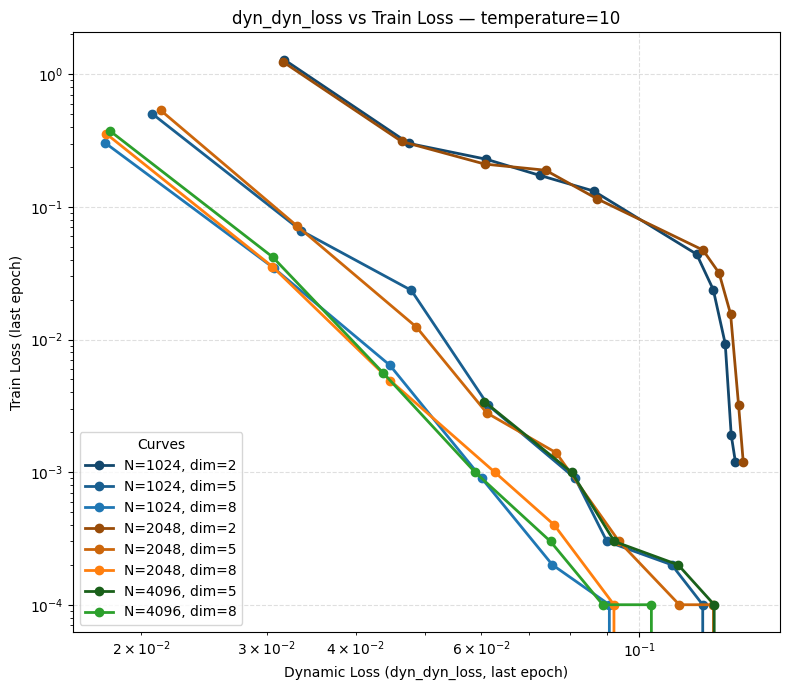

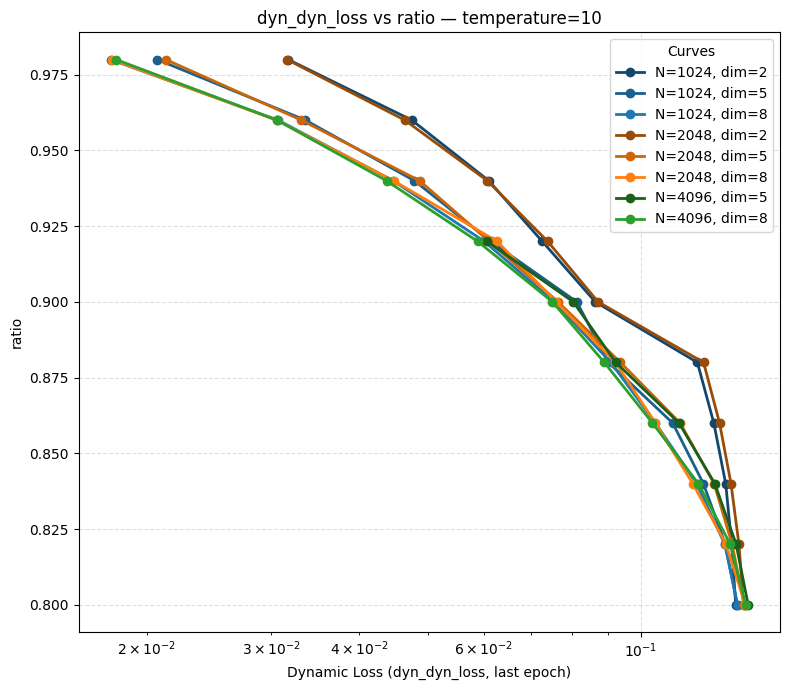

In [14]:

def plot_dyn_vs_train(results, Ns, t_filter):
    """
    绘图：
    - 横轴：dyn_dyn_loss（最后一个 epoch）
    - 纵轴：train_loss（最后一个 epoch）
    - 不同 N 使用不同颜色主色系
    - 同一 N 内：tp 从小到大 → 颜色从浅到深
    """

    fig, ax = plt.subplots(figsize=(8, 7))
    base_cmap = plt.get_cmap("tab10")

    for idx_N, N in enumerate(Ns):
        if N not in results:
            print(f"[Warning] N={N} not found; skip.")
            continue

        base_color = np.array(base_cmap(idx_N % 10))
        tp_list = sorted(results[N].keys())
        num_tp = len(tp_list)

        for i, tp in enumerate(tp_list):
            if t_filter not in results[N][tp]:
                continue

            # 颜色深浅（tp 小→浅）
            depth = 0.6 + 0.4 * (i / max(1, num_tp - 1))
            color = base_color.copy()
            color[:3] *= depth
            color = np.clip(color, 0, 1)

            # 提取所有 ratio 的点
            items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])

            dyn_vals   = [d["dyn_loss"]   for _, d in items]
            train_vals = [d["train_loss"] for _, d in items]

            # 过滤 None
            xy = [(x, y) for x, y in zip(dyn_vals, train_vals)
                  if x is not None and y is not None]
            if not xy:
                continue

            xs = [p[0] for p in xy]
            ys = [p[1] for p in xy]

            # 绘制曲线
            ax.plot(xs, ys,
                    marker="o",
                    linewidth=2,
                    color=color,
                    label=f"N={N}, dim={tp}")

    ax.set_xlabel("Dynamic Loss (dyn_dyn_loss, last epoch)")
    ax.set_ylabel("Train Loss (last epoch)")
    ax.set_title(f"dyn_dyn_loss vs Train Loss — temperature={t_filter}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(title="Curves")

    plt.tight_layout()
    plt.show()

def plot_dyn_vs_ratio(results, Ns, t_filter):
    """
    绘图：
    - 横轴：dyn_dyn_loss（最后一个 epoch）
    - 纵轴：ratio
    - 不同 N 使用不同颜色主色系
    - 同一 N 内：tp 从小到大 → 颜色从浅到深
    """

    fig, ax = plt.subplots(figsize=(8, 7))
    base_cmap = plt.get_cmap("tab10")

    for idx_N, N in enumerate(Ns):
        if N not in results:
            print(f"[Warning] N={N} not found; skip.")
            continue

        base_color = np.array(base_cmap(idx_N % 10))
        tp_list = sorted(results[N].keys())
        num_tp = len(tp_list)

        for i, tp in enumerate(tp_list):
            if t_filter not in results[N][tp]:
                continue

            # 颜色深浅（tp 小→浅）
            depth = 0.6 + 0.4 * (i / max(1, num_tp - 1))
            color = base_color.copy()
            color[:3] *= depth
            color = np.clip(color, 0, 1)

            # 获取 ratio 顺序的点
            items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])

            dyn_vals = []
            ratio_vals = []

            for r, d in items:
                if d["dyn_loss"] is not None:
                    dyn_vals.append(d["dyn_loss"])
                    ratio_vals.append(r)     # 纵轴变成 ratio

            if not dyn_vals:
                continue

            ax.plot(
                dyn_vals,
                ratio_vals,
                marker="o",
                linewidth=2,
                color=color,
                label=f"N={N}, dim={tp}"
            )

    ax.set_xlabel("Dynamic Loss (dyn_dyn_loss, last epoch)")
    ax.set_ylabel("ratio")
    ax.set_title(f"dyn_dyn_loss vs ratio — temperature={t_filter}")

    ax.set_xscale("log")
    # 纵轴 ratio 不适合 log（有 <1 区域），保持线性
    # ax.set_yscale("log")  # 不修改

    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(title="Curves")

    plt.tight_layout()
    plt.show()

Ns = [1024, 2048, 4096]
plot_dyn_vs_train(results, Ns, t_filter=10)
plot_dyn_vs_ratio(results, Ns, t_filter=10)

In [ ]:
import plotly.graph_objects as go

def plot_3d_ratio_train_valid_plotly(results, N, t_filter):
    fig = go.Figure()

    tp_list = sorted(results[N].keys())
    num_tp = len(tp_list)

    # 色系：PuBu 渐变
    import numpy as np
    cmap = plt.get_cmap("PuBu")
    colors = [cmap(v) for v in np.linspace(0.3, 1.0, num_tp)]

    for color, tp in zip(colors, tp_list):
        if t_filter not in results[N][tp]:
            continue

        items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])
        dyn_vals = [d["dyn_loss"] for _, d in items]
        train_vals = [d["train_loss"] for _, d in items]
        valid_vals = [d["valid_loss"] for _, d in items]

        # matplotlib color 转 plotly RGB
        rgb = f"rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})"

        fig.add_trace(go.Scatter3d(
            x=dyn_vals,
            y=train_vals,
            z=valid_vals,
            mode="lines+markers",
            marker=dict(size=4, color=rgb),
            line=dict(color=rgb, width=3),
            name=f"tp={tp}",
        ))

    fig.update_layout(
        width=850, height=700,
        scene=dict(
            xaxis_title="train loss",
            yaxis_title="dyn loss",
            zaxis_title="valid loss",
        ),
        title=f"3D Dyn–Train-Valid (N={N}, t={t_filter})"
    )
    
    fig.update_layout(scene=dict(
        xaxis=dict(type="log"),
        yaxis=dict(type="log"),
    ))

    fig.show()
plot_3d_ratio_train_valid_plotly(results, N=2048, t_filter=10)

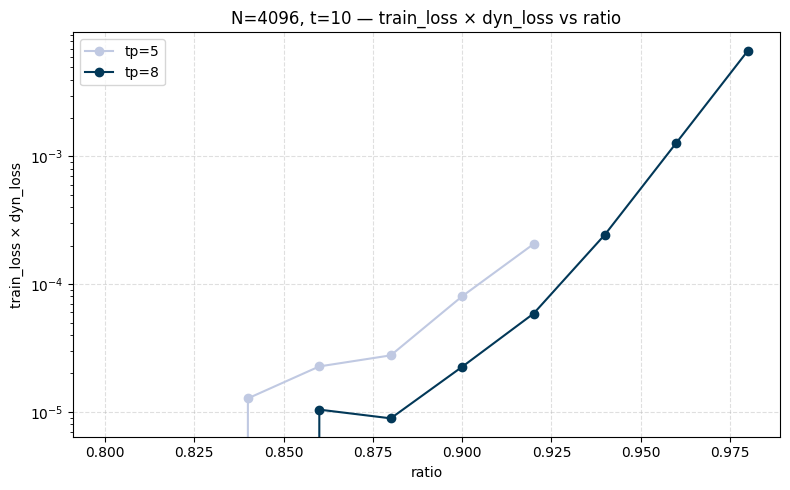

In [15]:
def plot_train_dyn_product(results, N, t_filter):
    """
    绘制 (train_loss * dyn_loss) vs ratio
    不同 tp 用渐变色（PuBu），横轴为 ratio。
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if N not in results:
        raise ValueError(f"No data for N={N}")

    tp_list = sorted(results[N].keys())
    num_tp = len(tp_list)

    # 专业科研渐变色 PuBu
    cmap = plt.get_cmap("PuBu")
    colors = [cmap(v) for v in np.linspace(0.3, 1.0, num_tp)]

    fig, ax = plt.subplots(figsize=(8, 5))

    for color, tp in zip(colors, tp_list):

        if t_filter not in results[N][tp]:
            continue

        # 获取最后一轮 epoch 的值：对每个 ratio
        items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])

        ratios = []
        product_vals = []

        for r, d in items:
            # train_loss * dyn_loss
            if "train_loss" in d and "dyn_loss" in d:
                ratios.append(r)
                product_vals.append(d["train_loss"] * d["dyn_loss"])

        if len(ratios) == 0:
            continue

        ax.plot(
            ratios,
            product_vals,
            marker="o",
            color=color,
            label=f"tp={tp}",
        )

    ax.set_xlabel("ratio")
    ax.set_ylabel("train_loss × dyn_loss")
    ax.set_title(f"N={N}, t={t_filter} — train_loss × dyn_loss vs ratio")
    ax.set_yscale("log")
    
    
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_train_dyn_product(results, N=4096, t_filter=10)
